In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as ptch
import numpy as np
import scipy.io as io
from scipy import interpolate

$$
\big|\vec{E}_{AM}(\vec{n}, \vec{r})\big| = \big|\big|\big(\vec{E_1}(\vec{r}) + \vec{E_2}(\vec{r})\big)\cdot\vec{n}\big| - \big|\big(\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big)\cdot\vec{n}\big|\big|
$$

$$
\big|\vec{E}_{AM}^{max}(\vec{r})\big|=
\begin{cases}
      2\big|\vec{E_2}(\vec{r})\big| & \text{if}\; \big|\vec{E_2}(\vec{r})\big| < \big|\vec{E_1}(\vec{r})\big|\cos\alpha \\
      2\dfrac{\big|\big|\vec{E_2}(\vec{r})\big|\times\big(\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big)\big|}{\big|\vec{E_1}(\vec{r}) - \vec{E_2}(\vec{r})\big|} & \text{otherwise}
\end{cases}
$$

In [8]:
def modulation_envelope(e_field_1, e_field_2, dir_vector=None):
    E_minus = np.subtract(e_field_1, e_field_2) # Create the difference of the E fields

    if dir_vector is None:
        envelope = np.zeros(e_field_1.shape[0])
        
        # Calculate the angles between the two fields for each vector
        dot_angle = np.einsum('ij,ij->i', e_field_1, e_field_2)
        cross_angle = np.linalg.norm(np.cross(e_field_1, e_field_2), axis=1)
        angles = np.arctan2(cross_angle, dot_angle)
        
        angs = np.einsum('ij,ij->i', e_field_1, e_field_2)/(np.multiply(np.linalg.norm(e_field_1, axis=1), 
                                                                      np.linalg.norm(e_field_2, axis=1)))
        
        # Condition to have two times the E2 field amplitude
        max_condition_1 = np.linalg.norm(e_field_2, axis=1) < np.linalg.norm(e_field_1, axis=1)*np.cos(angles)
        e1_gr_e2 = np.where(np.logical_and((np.linalg.norm(e_field_1, axis=1) > np.linalg.norm(e_field_2, axis=1)), angles < np.pi/2.), max_condition_1, False)
        
        # Condition to have two times the E1 field amplitude
        max_condition_2 = np.linalg.norm(e_field_1, axis=1) < np.linalg.norm(e_field_2, axis=1)*np.cos(angles)
        e2_gr_e1 = np.where(np.logical_and((np.linalg.norm(e_field_2, axis=1) > np.linalg.norm(e_field_1, axis=1)), angles < np.pi/2.), max_condition_2, False)
        
        # Double magnitudes
        envelope = np.where(e1_gr_e2, 2.0*np.linalg.norm(e_field_2, axis=1), envelope) # 2E2 (First case)
        envelope = np.where(e2_gr_e1, 2.0*np.linalg.norm(e_field_1, axis=1), envelope) # 2E1 (Second case)
        
        # Calculate the complement area to the previous calculation
        e1_gr_e2 = np.where(np.linalg.norm(e_field_1, axis=1) > np.linalg.norm(e_field_2, axis=1), np.logical_not(e1_gr_e2), False)
        e2_gr_e1 = np.where(np.linalg.norm(e_field_2, axis=1) > np.linalg.norm(e_field_1, axis=1), np.logical_not(e2_gr_e1), False)
        
        # Cross product
        envelope = np.where(e1_gr_e2, 2.0*(np.linalg.norm(np.cross(e_field_2, E_minus), axis=1)/np.linalg.norm(E_minus, axis=1)), envelope) # (First case)
        envelope = np.where(e2_gr_e1, 2.0*(np.linalg.norm(np.cross(e_field_1, -E_minus), axis=1)/np.linalg.norm(-E_minus, axis=1)), envelope) # (Second case)
    else:
        # Calculate the values of the E field modulation envelope along the desired n direction
        E_plus = np.add(e_field_1, e_field_2) # Create the difference of the E fields
        envelope = np.abs(np.abs(np.dot(E_plus, dir_vector)) - np.abs(np.dot(E_minus, dir_vector)))
    return np.nan_to_num(envelope)

## Import the data and calculate the grid points
According to the documentation provided by Sim4Life, the grid point coordinates are calculated as
$$\Bigg[\dfrac{Axis0(1) + Axis0(2)}{2}, \dfrac{Axis1(1) + Axis1(2)}{2}, \dfrac{Axis2(1) + Axis2(2)}{2}\bigg]$$
for each point.

In [3]:
base_data = io.loadmat('MATLAB Workspaces and Scripts/Workspaces/BaseFrequency4Layer_Smaller.mat')
delta_data = io.loadmat('MATLAB Workspaces and Scripts/Workspaces/DeltaFrequency4Layer_Smaller.mat')

# Replace possible NaN with 0
e_field_base = np.nan_to_num(base_data['EM_E_x_y_z_f0_Snapshot0'])
e_field_delta = np.nan_to_num(delta_data['EM_E_x_y_z_f0_Snapshot0'])

# Save the real part since the imaginary part is zero in the Ohmic current dominated domain
# Comment out the following if the simulation used produces complex valued field
e_field_base = np.real(e_field_base)
e_field_delta = np.real(e_field_delta)

# Same grid, so smae points. Assuming that both simulations have the exact same grid
x_axis = base_data['Axis0'][0]
y_axis = base_data['Axis1'][0]
z_axis = base_data['Axis2'][0]

# Generate grid points
x_avg = 0.5*np.add(x_axis[:-1], x_axis[1:])
y_avg = 0.5*np.add(y_axis[:-1], y_axis[1:])
z_avg = 0.5*np.add(z_axis[:-1], z_axis[1:])

grid_points = np.array(np.meshgrid(x_avg, y_avg, z_avg, indexing='ij')).T.reshape(-1, 3)

x_grid = np.unique(grid_points.T[0])
y_grid = np.unique(grid_points.T[1])
z_grid = np.unique(grid_points.T[2])

c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


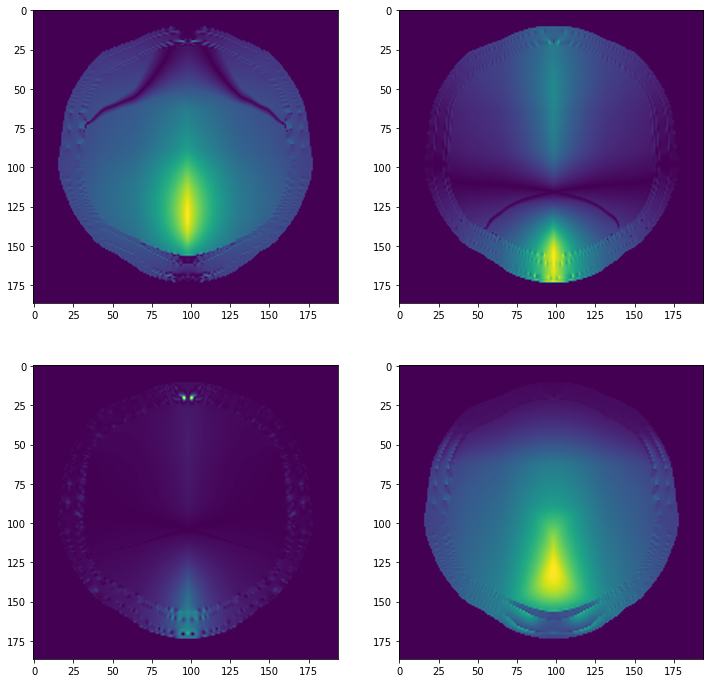

In [9]:
E_am = modulation_envelope(e_field_base, e_field_delta).reshape(-1, x_grid.size) # Arrange the elements across the x axis

z_index = 76

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2, 2, 4)
ax2 = fig.add_subplot(2, 2, 1)
ax3 = fig.add_subplot(2, 2, 2)
ax4 = fig.add_subplot(2, 2, 3)

ax.imshow(E_am[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax2.imshow(modulation_envelope(e_field_base, e_field_delta, [1, 0, 0]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')
ax3.imshow(modulation_envelope(e_field_base, e_field_delta, [0, 1, 0]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')
ax4.imshow(modulation_envelope(e_field_base, e_field_delta, [0, 0, 1]).reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, 
           interpolation="spline36", cmap='viridis')

plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(6856542,)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater


(6856542,) (6856542,)


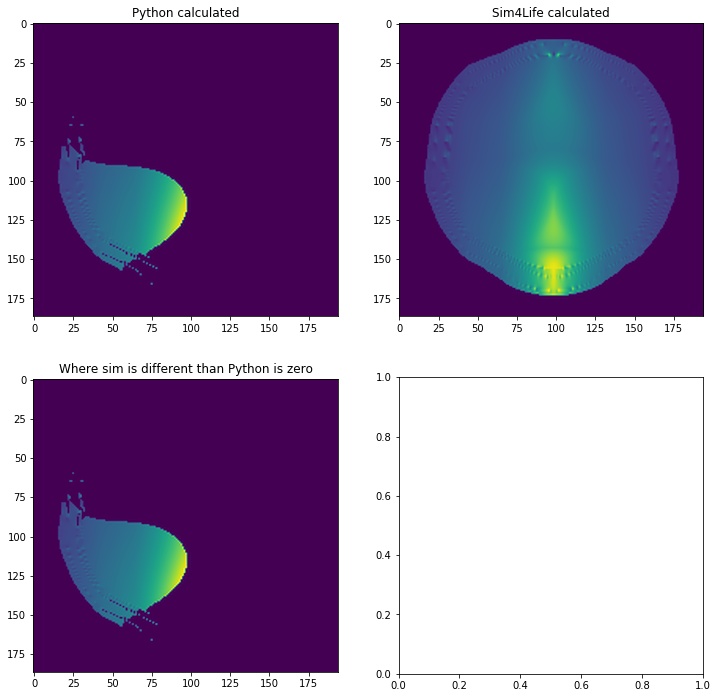

In [14]:
max_mod_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxMod1.11Trap.mat')
sim_modenv = np.nan_to_num(max_mod_data['Snapshot0']).T[0]

def condition(sim, calc):
    return np.around(sim, 4) != np.around(calc, 4)

calc_modenv = modulation_envelope(e_field_base, e_field_delta)
print(sim_modenv.shape, calc_modenv.shape)

#new_modenv = np.where(condition(sim_modenv, calc_modenv), 0, calc_modenv)
new_modenv = np.where(sim_modenv != calc_modenv, 0, calc_modenv)

#rec_env = np.where(sim_modenv != calc_modenv, rec_env, calc_modenv)

z_index = 76

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax.imshow(calc_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax.set_title('Python calculated')

ax2.imshow(sim_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax2.set_title('Sim4Life calculated')

ax3.imshow(new_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax3.set_title('Where sim is different than Python is zero')

#ax4.imshow(rec_env.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
#ax4.set_title('Sequential reconstruction')

#fig.savefig("SimAndClalc.png", bbox_inches='tight', dpi=150)

plt.show()

c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(6856542,)


c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


Max of angles  : 179.83157468011785 
Max of angles 2: 179.9131663052324
All angles are common: [False]


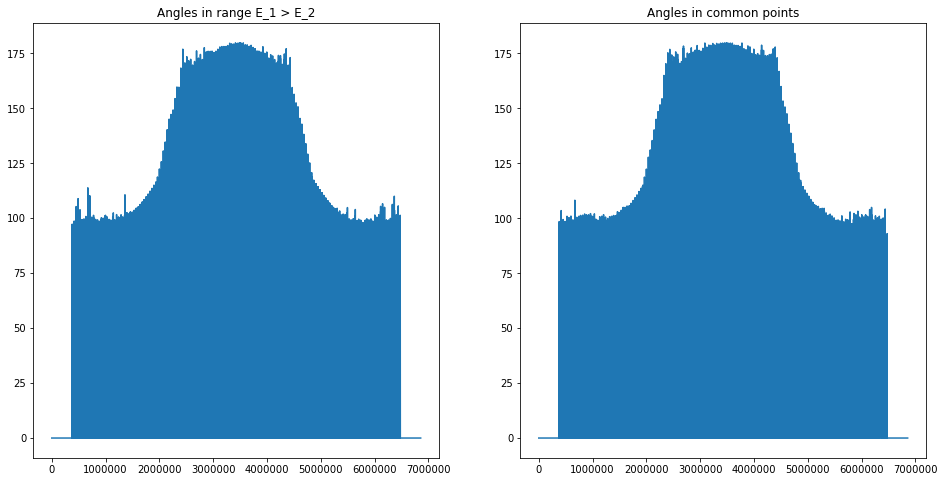

In [165]:
#degs = modulation_envelope(e_field_base, e_field_delta, test=np.where(sim_modenv != calc_modenv, False, True))
degs = modulation_envelope(e_field_base, e_field_delta, test=grid_points)

degs_1 = np.where(np.linalg.norm(e_field_delta, axis=1) < np.linalg.norm(e_field_base, axis=1)*np.cos(np.rad2deg(degs)), degs, 0)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.plot(degs_1)
ax.set_title('Angles in range E_1 > E_2')
#ax.set_ylim(0, 90)

degs_2 = np.where(sim_modenv != calc_modenv, 0, degs)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(degs_2)
ax2.set_title('Angles in common points')
#ax2.set_ylim(0, 90)

print("Max of angles  :", np.amax(degs_1), "\nMax of angles 2:", np.amax(degs_2))
print("All angles are common:", np.sum(degs == degs_2) == degs.shape)

plt.show()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(6856542,)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater



494


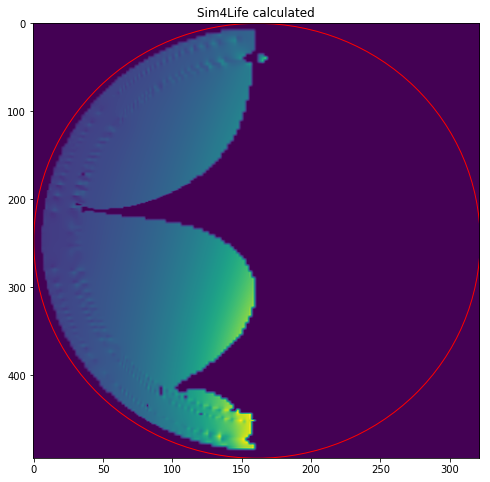

In [5]:
max_mod_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxMod1.11Trap.mat')
sim_modenv = np.nan_to_num(max_mod_data['Snapshot0']).T[0]
#print(sim_modenv)

calc_modenv = modulation_envelope(e_field_base, e_field_delta)

new_modenv = np.where(sim_modenv != calc_modenv, 0, calc_modenv)

z_index = 76

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
#ax2 = fig.add_subplot(1, 3, 2)
#ax3 = fig.add_subplot(1, 3, 3)

# Reduce the grid and find the new data and axis points
grid_cut = 0.09 # Point up to which the grid is used

base_field = np.nan_to_num(e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])

# New axis points
x_cut = np.where(np.logical_or(x_grid < -grid_cut, x_grid > grid_cut), False, True)
y_cut = np.where(np.logical_or(y_grid < -grid_cut, y_grid > grid_cut), False, True)

x_cut = x_grid[x_cut]
y_cut = y_grid[y_cut]

# New data points
x_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0]
y_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1]

x_grid_new = np.invert(np.logical_or(x_grid_new < -grid_cut, x_grid_new > grid_cut))
y_grid_new = np.invert(np.logical_or(y_grid_new < -grid_cut, y_grid_new > grid_cut))
common_grid_points = np.logical_and(x_grid_new, y_grid_new)

print()
sm = sim_modenv[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]
sm = sm[common_grid_points]

axis_1_step = np.ceil(1. + (x_cut[-1] - x_cut[0])/np.amin(np.diff(x_cut)))
#axis_2_step = (np.amax(np.diff(y_grid)) - np.amin(np.diff(y_grid)))/2.
axis_2_step = np.ceil(1. + (y_cut[-1] - y_cut[0])/np.amin(np.diff(y_cut)))

axis_1_interp = np.linspace(x_cut[0], x_cut[-1], np.int16(axis_1_step))
axis_2_interp = np.linspace(y_cut[0], y_cut[-1], np.int16(axis_2_step))

data_points_u = interpolate.interp2d(x_cut, y_cut, sm.reshape(-1, x_cut.size), kind='linear')
sim_data_interp = data_points_u(axis_1_interp, axis_2_interp)

nm = new_modenv[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]
nm = nm[common_grid_points]

calc_interp = interpolate.interp2d(x_cut, y_cut, nm.reshape(-1, x_cut.size), kind='linear')
calc_interp = calc_interp(axis_1_interp, axis_2_interp)

#ax.imshow(calc_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
#ax.set_title('Python calculated')

#sim_modenv = np.array(np.where(calc_modenv > 0, sim_modenv, 0))
#ax.imshow(sim_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax.imshow(calc_interp.T, cmap='viridis', interpolation="spline36", aspect='auto')
ax.set_title('Sim4Life calculated')

#ax3.imshow(new_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
#ax3.set_title('If Simulation ≠ Python then zero')

#fig.savefig("SimImage.png", bbox_inches='tight', dpi=150)
circ = ptch.Ellipse((axis_2_interp.size/2., axis_1_interp.size/2.), axis_2_interp.size, axis_1_interp.size, color='r', fill=False)
ax.add_patch(circ)
print(axis_1_interp.size)

plt.show()

## Calculating sequential reconstruction

In [207]:
def modulation_envelope_2(e_field_1, e_field_2, dir_vector=None):
    E_plus = np.add(e_field_1, e_field_2) # Create the sum of the E fields
    E_minus = np.subtract(e_field_1, e_field_2) # Create the difference of the E fields

    if dir_vector is 1:
        # Calculate the maximum envelope
        return np.nan_to_num(2.0*np.linalg.norm(e_field_2, axis=1))
    elif dir_vector is 2:
        return np.nan_to_num(2.0*np.linalg.norm(e_field_1, axis=1))
    elif dir_vector is 3:
        return np.nan_to_num(2.0*(np.linalg.norm(np.cross(e_field_2, E_minus), axis=1)/np.linalg.norm(E_minus, axis=1)))
    elif dir_vector is 4:
        return np.nan_to_num(2.0*(np.linalg.norm(np.cross(e_field_1, E_plus), axis=1)/np.linalg.norm(E_plus, axis=1)))
    elif dir_vector is 5:
        return np.nan_to_num(2.0*(np.linalg.norm(np.cross(e_field_1, E_minus), axis=1)/np.linalg.norm(E_minus, axis=1)))


E_1 and E_2 double region
Calculation: 0.75178784 0.045555804
Simulation : 0.75178784 0.045555804 


E_1 and E_2 cross region


c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Calculation: 0.5559292 0.057198644
Simulation : 0.5559292 0.057198644 



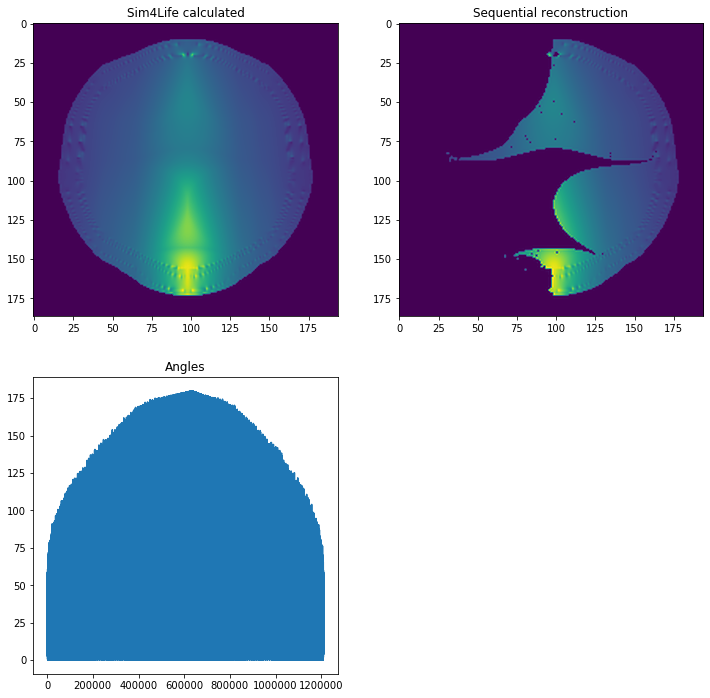

179.85097


In [244]:
max_mod_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxMod1.11Trap.mat')
sim_modenv = np.nan_to_num(max_mod_data['Snapshot0']).T[0]
rec_env = np.zeros(sim_modenv.size)

# Reconstruction
def condition(sim, calc):
    error = 1e-6
    non_z_calc = np.logical_and(calc != 0, sim == calc)
    non_z_sim = np.logical_and(sim != 0, sim == calc)
    print("Calculation:", np.amax(calc[non_z_calc]), np.amin(calc[non_z_calc]))
    print("Simulation :", np.amax(sim[non_z_sim]), np.amin(sim[non_z_sim]), "\n")
    return np.around(sim, 6) != np.around(calc, 6)

# 2E2
print("\nE_1 and E_2 double region")
calc_modenv = modulation_envelope_2(e_field_base, e_field_delta, dir_vector=1)
rec_env = np.where(condition(sim_modenv, calc_modenv), rec_env, calc_modenv)

# 2E1
calc_modenv = modulation_envelope_2(e_field_base, e_field_delta, dir_vector=2)
rec_env = np.where(condition(sim_modenv, calc_modenv), rec_env, calc_modenv)

# 2E2 cross
print("\nE_1 and E_2 cross region")
#calc_modenv = modulation_envelope_2(e_field_base, e_field_delta, dir_vector=3)
#rec_env = np.where(condition(sim_modenv, calc_modenv), rec_env, calc_modenv)

# 2E1 cross
#calc_modenv = modulation_envelope_2(e_field_base, e_field_delta, dir_vector=4)
#rec_env = np.where(condition(sim_modenv, calc_modenv), rec_env, calc_modenv)

#dot_angle = np.einsum('ij,ij->i', e_field_base, (e_field_base + e_field_delta))
#cross_angle = np.linalg.norm(np.cross(e_field_base, (e_field_base + e_field_delta)), axis=1)
dot_angle = np.einsum('ij,ij->i', e_field_base, (e_field_base + e_field_delta))
cross_angle = np.linalg.norm(np.cross(e_field_base, (e_field_base + e_field_delta)), axis=1)
angles = np.arctan2(cross_angle, dot_angle)
#angles = np.arctan2(e_field_delta[:, 1], e_field_delta[:, 0]) - np.arctan2(e_field_base[:, 1], e_field_base[:, 0])
#angles = np.arctan2((e_field_base + e_field_delta)[:, 1], (e_field_base + e_field_delta)[:, 0]) - np.arctan2(e_field_base[:, 1], e_field_base[:, 0])

z_index = 76

fig = plt.figure(figsize=(12, 12))
#ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 1)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 2)

#ax.imshow(calc_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
#ax.set_title('Python calculated')

ax2.imshow(sim_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax2.set_title('Sim4Life calculated')

ax3.plot(np.rad2deg(angles[rec_env != 0]))
#ax3.plot(np.rad2deg(angles))
ax3.set_title('Angles')

ax4.imshow(rec_env.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax4.set_title('Sequential reconstruction')

plt.show()

print(np.amax(np.rad2deg(angles[rec_env != 0])))

Q: 9688.441
10385.608
(43, 168)


c:\users\dimitris\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


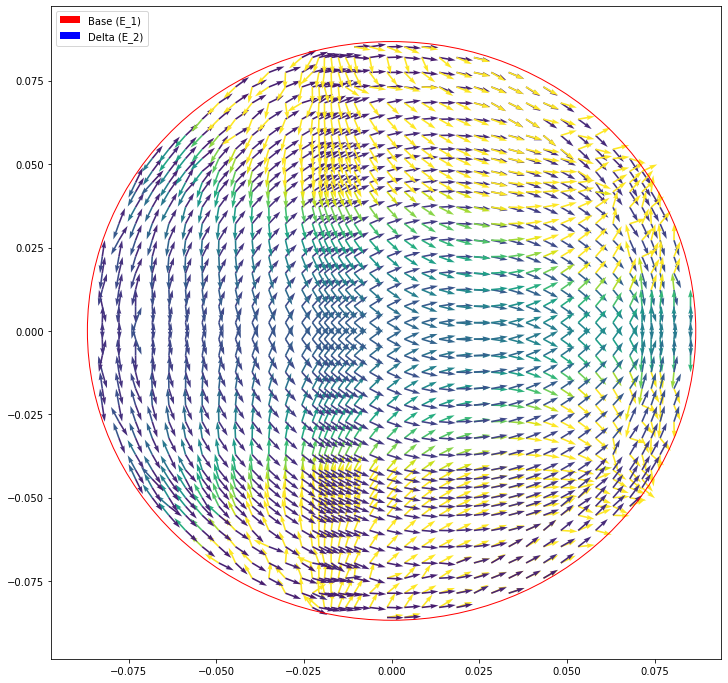

In [615]:
def normalize(x, y):
    return x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)
#Quiver plot

#print(e_field_base.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].shape)
q_1 = np.nan_to_num(e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])
q = np.nan_to_num(e_field_delta[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])

max_mod_data_grad = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxModFrequency4Layer_Smaller_Grad.mat')
sim_dat = np.nan_to_num(max_mod_data_grad['Snapshot0'])[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]

#print(sim_dat.shape)

#q = np.where(np.logical_or(q < -0.5, q > 0.5), 0, q)
#q_1 = np.where(np.logical_or(q_1 < -0.5, q_1 > 0.5), 0, q_1)
#sim_dat = np.where(np.logical_or(sim_dat < -0.5, sim_dat > 0.5), 0, sim_dat)
#q = np.where(np.linalg.norm(q, axis=1) > 10, 0, q)
#q_1 = np.where(np.linalg.norm(q_1, axis=1) > 10, 0, q_1)
print("Q:", np.amax(q))
print(np.amax(np.linalg.norm(q_1, axis=1)))

q_a = q + q_1
q_d = q - q_1

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1)

# Skip points
skip_int = 4
skip_1 = (slice(None, None, skip_int))
skip_2 = (slice(None, None, skip_int), slice(None, None, skip_int))

# Reduce the grid
grid_cut = 0.09

x_cut = np.where(np.logical_or(x_grid < -grid_cut, x_grid > grid_cut), False, True)
y_cut = np.where(np.logical_or(y_grid < -grid_cut, y_grid > grid_cut), False, True)

x_cut = x_grid[x_cut]
y_cut = y_grid[y_cut]

x_gr_p = np.invert(np.logical_or(grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0] < -grid_cut, 
                                 grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0] > grid_cut))
y_gr_p = np.invert(np.logical_or(grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1] < -grid_cut, 
                                 grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1] > grid_cut))
common_points = np.logical_and(x_gr_p, y_gr_p)

# Data points
q_1 = q_1[common_points]
q = q[common_points]
sim_dat = sim_dat[common_points]

#q_1[np.linalg.norm(q_1, axis=1) > 1, :] = 0

# Normalize the arrows:
# https://stackoverflow.com/questions/44780933/matplotlib-quiver-plotting-with-constant-arrow-size
#x_quiv = q_1[:, 0].reshape(-1, x_cut.size)[skip_2]
#y_quiv = q_1[:, 1].reshape(-1, x_cut.size)[skip_2]

#print(x_quiv.shape)

#x_quiv = x_quiv / np.sqrt(x_quiv**2 + y_quiv**2)
#y_quiv = y_quiv / np.sqrt(x_quiv**2 + y_quiv**2)

print(np.linalg.norm(q_1[:, 0:2], axis=1).reshape(-1, x_cut.size)[skip_1].shape)

# Plot quiver
ax.quiver(x_cut[skip_1], y_cut[skip_1], *normalize(q_1[:, 0].reshape(-1, x_cut.size)[skip_2], q_1[:, 1].reshape(-1, x_cut.size)[skip_2]), 
          np.linalg.norm(q_1[:, 0:2], axis=1).reshape(-1, x_cut.size)[skip_2], units='width', scale=40, label='Base (E_1)', clim=[0, 0.5], cmap='viridis', color='red')
ax.quiver(x_cut[skip_1], y_cut[skip_1], *normalize(q[:, 0].reshape(-1, x_cut.size)[skip_2], q[:, 1].reshape(-1, x_cut.size)[skip_2]), 
          np.linalg.norm(q[:, 0:2], axis=1).reshape(-1, x_cut.size)[skip_2], units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5], cmap='viridis', color='blue')
#ax.quiver(x_cut[skip_1], y_cut[skip_1], q[:, 0].reshape(-1, x_cut.size)[skip_2], q[:, 1].reshape(-1, x_cut.size)[skip_2], 
#          angles='uv', units='height', scale=10, color='blue', label='Delta (E_2)')
#ax.quiver(x_cut[skip_1], y_cut[skip_1], sim_dat[:, 0].reshape(-1, x_cut.size)[skip_2], sim_dat[:, 1].reshape(-1, x_cut.size)[skip_2], 
#          angles='uv', units='height', scale=10, color='orange', label='Simulation')
#ax.quiver(x_grid[skip_1], y_grid[skip_1], q_1[:, 0].reshape(-1, x_grid.size)[skip_2], q_1[:, 1].reshape(-1, x_grid.size)[skip_2], 
#          angles='uv', units='height', scale=10, color='red', label='Base (E_1)')
#ax.quiver(x_grid[skip_1], y_grid[skip_1], q[:, 0].reshape(-1, x_grid.size)[skip_2], q[:, 1].reshape(-1, x_grid.size)[skip_2], 
#          angles='uv', units='height', scale=10, color='blue',  label='Delta (E_2)')
#ax.quiver(x_grid[skip_1], y_grid[skip_1], q_a[:, 0].reshape(-1, x_grid.size)[skip_2], q_a[:, 1].reshape(-1, x_grid.size)[skip_2], 
#          angles='uv', units='height', scale=20, color='green')
#ax.quiver(x_grid[skip_1], y_grid[skip_1], q_d[:, 0].reshape(-1, x_grid.size)[skip_2], q_d[:, 1].reshape(-1, x_grid.size)[skip_2], 
#          angles='uv', units='height', scale=20, color='purple')
#ax.quiver(x_grid[skip_1], y_grid[skip_1], sim_dat[:, 0].reshape(-1, x_grid.size)[skip_2], sim_dat[:, 1].reshape(-1, x_grid.size)[skip_2], 
#          angles='uv', units='height', scale=10, color='orange')
#ax.set_title('Python calculated')
#ax.quiver(x_cut[skip_1], y_cut[skip_1], *normalize(sim_dat[:, 0].reshape(-1, x_cut.size)[skip_2], sim_dat[:, 1].reshape(-1, x_cut.size)[skip_2]), 
#          np.linalg.norm(sim_dat[:, 0:2], axis=1).reshape(-1, x_cut.size)[skip_2], units='width', scale=40, label='Simulation', clim=[0, 0.5], cmap='viridis', color='red')
circ = plt.Circle((0, 0), 0.08675, color='r', fill=False)
ax.add_artist(circ)
ax.legend()

plt.show()

In [6]:
# Data interpolation
def grid_regularization(axis_1, axis_2, data_points, method='linear'):
    axis_1_step = np.uint32(np.ceil(1. + (axis_1[-1] - axis_1[0])/np.amin(np.diff(axis_1))))
    axis_2_step = np.uint32(np.ceil(1. + (axis_2[-1] - axis_2[0])/np.amin(np.diff(axis_2))))

    axis_1_interp = np.linspace(axis_1[0], axis_1[-1], axis_1_step)
    axis_2_interp = np.linspace(axis_2[0], axis_2[-1], axis_2_step)
    print(axis_2_interp.shape)

    data_points_u = interpolate.interp2d(axis_1, axis_2, data_points[:, 0].reshape(-1, axis_1.size), kind=method)
    data_points_u = data_points_u(axis_1_interp, axis_2_interp).reshape(-1, 1)
    #data_points_v = data_points_u
    
    #data_points_u = interpolate.RegularGridInterpolator((axis_1, axis_2), data_points[:, 0].reshape(-1, axis_1.size).T)
    #ar = np.asarray(np.meshgrid(axis_1_interp, axis_2_interp, indexing='ij')).T
    #data_points_u = data_points_u(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))

    data_points_v = interpolate.interp2d(axis_1, axis_2, data_points[:, 1].reshape(-1, axis_1.size), kind=method)
    data_points_v = data_points_v(axis_1_interp, axis_2_interp).reshape(-1, 1)

    return axis_1_interp, axis_2_interp, np.hstack((data_points_u, data_points_v))
    #return axis_1_interp, axis_2_interp, data_points_u, data_points_v

#print(len((x_cut)))
#print(base_field[:, 0].reshape(-1, x_cut.size).shape)
#print(np.asarray(np.meshgrid(x_cut, y_cut, indexing='ij')).T[:,:,1].shape)
#x_int, y_int, base_u, base_v = grid_regularization(x_cut, y_cut, base_field)
#print(np.sum(base_u == base_v.T[0]))

Common: 28560
BaseGr: (28560, 3)
(322,)
(322,)
(322,)
(322,)
(322,)
(322,)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


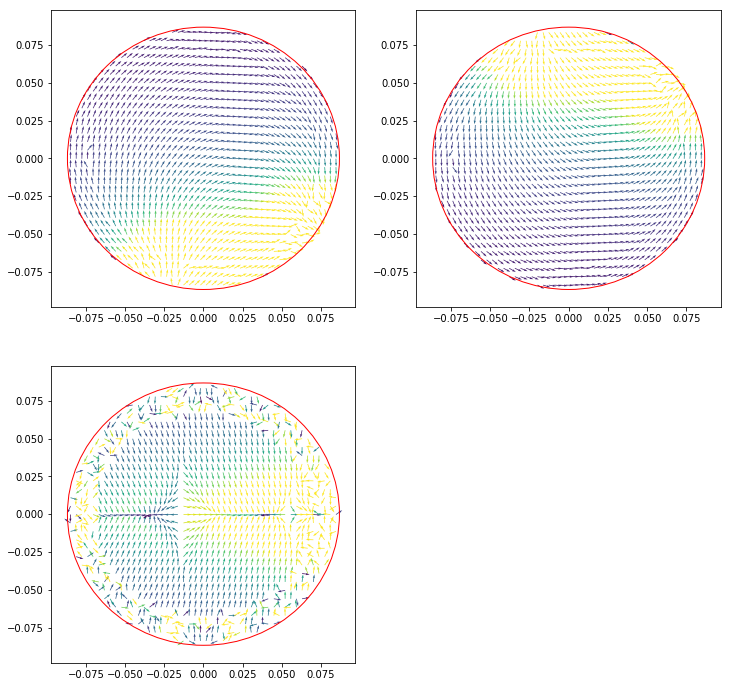

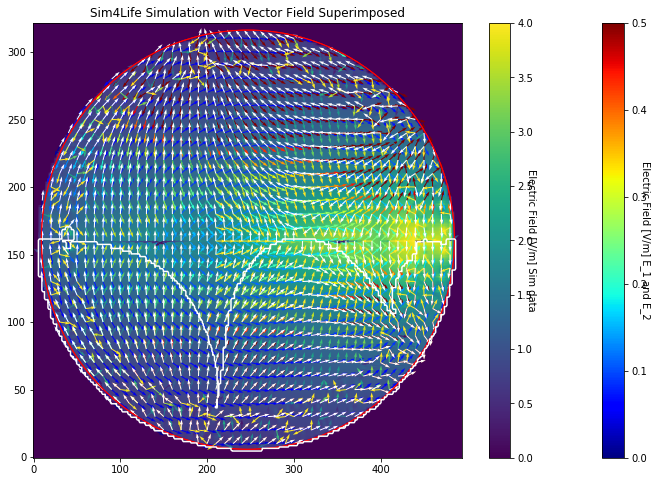

In [25]:
# Function to normalize the vector length
def normalize(x, y):
    return x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2)

# Get the field values for the specific Z slice
z_index = 76
base_field = np.nan_to_num(e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])
delta_field = np.nan_to_num(e_field_delta[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])

# Import the gradient of the simulation data, generated within Sim4Life
max_mod_data_grad = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxModFrequency4Layer_Smaller_Grad.mat')
sim_data = np.nan_to_num(max_mod_data_grad['Snapshot0'])[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]

# Create the figure for the plot and add a subplot
fig = plt.figure(figsize=(12, 12))
ax_1 = fig.add_subplot(2, 2, 1)
ax_2 = fig.add_subplot(2, 2, 2)
ax_3 = fig.add_subplot(2, 2, 3)

# Skip grid points for better visualization
skip_int = 10 # Skipping step
skip_1 = (slice(None, None, skip_int))
skip_2 = (slice(None, None, skip_int), slice(None, None, skip_int))

# Reduce the grid and find the new data and axis points
grid_cut = 0.09 # Point up to which the grid is used

# New axis points
x_cut = np.where(np.logical_or(x_grid < -grid_cut, x_grid > grid_cut), False, True)
y_cut = np.where(np.logical_or(y_grid < -grid_cut, y_grid > grid_cut), False, True)

x_cut = x_grid[x_cut]
y_cut = y_grid[y_cut]

# New data points
x_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0]
y_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1]

x_grid_new = np.invert(np.logical_or(x_grid_new < -grid_cut, x_grid_new > grid_cut))
y_grid_new = np.invert(np.logical_or(y_grid_new < -grid_cut, y_grid_new > grid_cut))
common_grid_points = np.logical_and(x_grid_new, y_grid_new)

base_field = base_field[common_grid_points, :]
delta_field = delta_field[common_grid_points, :]
sim_data = sim_data[common_grid_points, :]

print("Common:", np.sum(common_grid_points))
#print(x_grid_new < -grid_cut)
#print(x_grid_new > grid_cut)
#print(np.invert(np.logical_or(x_grid_new < -grid_cut, x_grid_new > grid_cut)))
#print(np.invert(np.logical_or(y_grid_new < -grid_cut, y_grid_new > grid_cut)))
print("BaseGr:", base_field.shape)
#print(np.logical_and(np.invert(np.logical_or(x_grid_new < -grid_cut, x_grid_new > grid_cut)), np.invert(np.logical_or(y_grid_new < -grid_cut, y_grid_new > grid_cut))))


# Plot the quiver plot
x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, base_field)
ax_1.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2], 
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]), 
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Base (E_1)', clim=[0, 0.5],cmap='viridis',
          color='red')

x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, delta_field)
ax_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]),
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5],cmap='viridis',
          color='blue')

x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, sim_data)
ax_3.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]),
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Simulation', clim=[0, 5],cmap='viridis',
          color='yellow')
"""
ax_3.quiver(x_cut[skip_1], y_cut[skip_1], *normalize(sim_data[:, 0].reshape(-1, x_cut.size)[skip_2],
          sim_data[:, 1].reshape(-1, x_cut.size)[skip_2]),
          np.linalg.norm(sim_data[:, 0:2], axis=1).reshape(-1, x_cut.size)[skip_2],
          units='width', scale=40, label='Simulation', clim=[0, 0.5],cmap='viridis',
          color='yellow')
"""
# Plot a circle representing the modeled sphere
head_radius = 0.08675
circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_1.add_artist(circ)

circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_2.add_artist(circ)

circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
ax_3.add_artist(circ)

#fig.savefig("VectorFieldInterp.png", bbox_inches='tight', dpi=150)

# Add a legend and plot the graph
#ax.legend()


fig_2 = plt.figure(figsize=(12, 8))
ax_f_2 = fig_2.add_subplot(1, 1, 1)

#ax_f_2.imshow(calc_interp, origin='lower', cmap='viridis', interpolation='none', aspect='auto')
ax_f_2.imshow(sim_data_interp, origin='lower', cmap='viridis', interpolation='none', aspect='auto')
ax_f_2.contour(calc_interp, levels=[245], colors='white', origin='lower')

x_int, y_int, base_uv = grid_regularization(x_cut, y_cut, base_field)
x_int = np.arange(0, x_int.size, 1)
y_int = np.arange(0, y_int.size, 1)
qvr = ax_f_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv[:, 0].reshape(-1, x_int.size)[skip_2], 
          base_uv[:, 1].reshape(-1, x_int.size)[skip_2]), 
          np.linalg.norm(base_uv[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Base (E_1)', clim=[0, 0.5],cmap='jet',
          color='red')
cbar = fig_2.colorbar(qvr, ax=ax_f_2)
cbar.ax.set_ylabel('Electric Field [V/m] E_1 and E_2', rotation=270)

x_int_1, y_int_1, base_uv_1 = grid_regularization(x_cut, y_cut, delta_field)
ax_f_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv_1[:, 0].reshape(-1, x_int.size)[skip_2],
          base_uv_1[:, 1].reshape(-1, x_int.size)[skip_2]),
          np.linalg.norm(base_uv_1[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
          units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5],cmap='jet',
          color='blue')

x_int_2, y_int_2, base_uv_sim = grid_regularization(x_cut, y_cut, sim_data)
qvr_sim = ax_f_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv_sim[:, 0].reshape(-1, x_int.size)[skip_2],
              base_uv_sim[:, 1].reshape(-1, x_int.size)[skip_2]),
              np.linalg.norm(base_uv_sim[:, 0:2], axis=1).reshape(-1, x_int.size)[skip_2],
              units='width', scale=40, label='Simulation', color='white', cmap='viridis', clim=[0, 4])

cbar = fig_2.colorbar(qvr_sim, ax=ax_f_2)
cbar.ax.set_ylabel('Electric Field [V/m] Sim data', rotation=270)

# Addition
#ax_f_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(base_uv_1[:, 0].reshape(-1, x_int.size)[skip_2] + base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
#              base_uv_1[:, 1].reshape(-1, x_int.size)[skip_2] + base_uv[:, 1].reshape(-1, x_int.size)[skip_2]),
#              units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5],cmap='jet',
#              color='white')

# Difference
ax_f_2.quiver(x_int[skip_1], y_int[skip_1], *normalize(-base_uv_1[:, 0].reshape(-1, x_int.size)[skip_2] + base_uv[:, 0].reshape(-1, x_int.size)[skip_2],
              -base_uv_1[:, 1].reshape(-1, x_int.size)[skip_2] + base_uv[:, 1].reshape(-1, x_int.size)[skip_2]),
              units='width', scale=40, label='Delta (E_2)', clim=[0, 0.5],cmap='jet',
              color='white')
#ax_f_2.set_facecolor('grey')

elps = ptch.Ellipse((x_int.size/2., y_int.size/2.), x_int.size*(head_radius/grid_cut), y_int.size*(head_radius/grid_cut), color='r', fill=False)
ax_f_2.add_patch(elps)

elps = ptch.Ellipse((x_int.size/2., y_int.size/2.), x_int.size*(head_radius/grid_cut), y_int.size*(head_radius/grid_cut), color='r', fill=False)
ax_f_2.add_patch(elps)

ax_f_2.set_title('Sim4Life Simulation with Vector Field Superimposed')

#circ = plt.Circle((0, 0), head_radius, color='r', fill=False)
#ax_f_2.add_artist(circ)

fig_2.savefig("VectorFieldInterpWithImage.png", bbox_inches='tight', dpi=300)


plt.show()

In [806]:
# Reduce the grid and find the new data and axis points
grid_cut = 0.08 # Point up to which the grid is used

base_field = np.nan_to_num(e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size])

# New axis points
x_cut = np.where(np.logical_or(x_grid < -grid_cut, x_grid > grid_cut), False, True)
y_cut = np.where(np.logical_or(y_grid < -grid_cut, y_grid > grid_cut), False, True)

x_cut = x_grid[x_cut]
y_cut = y_grid[y_cut]

# New data points
x_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 0]
y_grid_new = grid_points[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size][:, 1]

x_grid_new = np.invert(np.logical_or(x_grid_new < -grid_cut, x_grid_new > grid_cut))
y_grid_new = np.invert(np.logical_or(y_grid_new < -grid_cut, y_grid_new > grid_cut))
common_grid_points = np.logical_and(x_grid_new, y_grid_new)

print("X cond:", np.sum(x_grid_new))
print("Y cond:", np.sum(y_grid_new))
print("Common:", np.sum(common_grid_points))

base_field = base_field[common_grid_points, :]
print("Base:", base_field.shape)

X cond: 29682
Y cond: 27676
Common: 22644
Base: (22644, 3)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(6856542,)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


(6856542,) (6856542,)


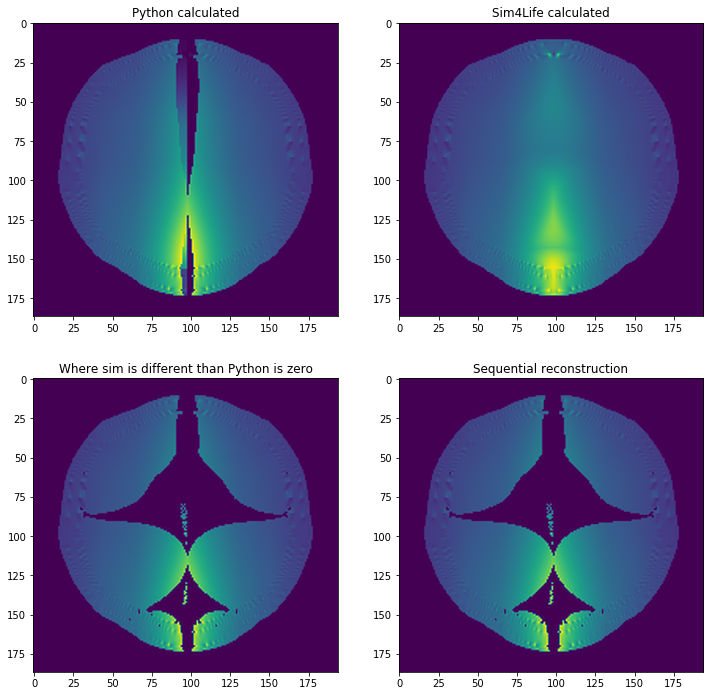

In [20]:
# Data interpolation
def grid_regularization_3d(axis_1, axis_2, axis_3, data_points, method='linear'):
    axis_1_step = np.uint32(np.ceil(1. + (axis_1[-1] - axis_1[0])/np.amin(np.diff(axis_1))))
    axis_2_step = np.uint32(np.ceil(1. + (axis_2[-1] - axis_2[0])/np.amin(np.diff(axis_2))))
    #axis_3_step = np.uint32(np.ceil(1. + (axis_3[-1] - axis_3[0])/np.amin(np.diff(axis_3))))

    axis_1_interp = np.linspace(axis_1[0], axis_1[-1], axis_1_step)
    axis_2_interp = np.linspace(axis_2[0], axis_2[-1], axis_2_step)
    #axis_3_interp = np.linspace(axis_3[0], axis_3[-1], axis_3_step)
    
    """
    print(np.asarray(np.meshgrid(axis_1_interp, axis_2_interp, axis_3_interp, indexing='ij', copy=False)).shape)

    print("Ax:", data_points[:, 2].reshape(-1, axis_1.size).T.reshape(-1, axis_2.size).T.shape)
    print("Ax:", data_points[:, 2].reshape(-1, axis_1.size).T.reshape(-1, axis_2.size).T.reshape(-1, axis_3.size).shape)
    data_points_x = interpolate.RegularGridInterpolator((axis_1, axis_3), data_points[:, 2].reshape(-1, axis_1.size).T)
    ar = np.asarray(np.meshgrid(axis_1_interp, axis_3_interp, indexing='ij', copy=False))
    print("Array:", ar)
    data_points_x = data_points_x(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))
    
    data_points_y = interpolate.RegularGridInterpolator((axis_2, axis_3), data_points[:, 2].reshape(-1, axis_1.size).T)
    ar = np.asarray(np.meshgrid(axis_2_interp, axis_3_interp, indexing='ij', copy=False))
    print("Array:", ar)
    data_points_y = data_points_y(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))
    """
    
    
    data_points_x = interpolate.RegularGridInterpolator((axis_1, axis_2), np.moveaxis(data_points[:, 0].reshape((-1, axis_1.size)), 0, -1))
    ar = np.asarray(np.meshgrid(axis_1_interp, axis_2_interp, indexing='ij', copy=False)).T
    data_points_x = data_points_x(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))

    data_points_y = interpolate.RegularGridInterpolator((axis_1, axis_2), np.moveaxis(data_points[:, 1].reshape((-1, axis_1.size)), 0, -1))
    #ar = np.asarray(np.meshgrid(axis_1_interp, axis_2_interp, axis_3_interp, indexing='ij')).T
    data_points_y = data_points_y(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))
    
    data_points_z = interpolate.RegularGridInterpolator((axis_1, axis_2), np.moveaxis(data_points[:, 2].reshape((-1, axis_1.size)), 0, -1))
    #ar = np.asarray(np.meshgrid(axis_1_interp, axis_2_interp, axis_3_interp, indexing='ij')).T
    data_points_z = data_points_z(np.hstack((ar[:, :, 0].reshape(-1, 1), ar[:, :, 1].reshape(-1, 1))))
    
    return axis_1_interp, axis_2_interp, np.hstack((data_points_x, data_points_y, data_points_z))
    #return axis_1_interp, axis_2_interp, np.hstack((data_points_x, data_points_y))

max_mod_data = io.loadmat('../MATLAB Workspaces and Scripts/Workspaces/MaxMod1.11Trap.mat')
sim_modenv = np.nan_to_num(max_mod_data['Snapshot0']).T[0]
rec_env = np.zeros(sim_modenv.size)

def condition(sim, calc):
    return np.around(sim, 4) != np.around(calc, 4)

calc_modenv = modulation_envelope(e_field_base, e_field_delta)
print(sim_modenv.shape, calc_modenv.shape)

#x_1, y_1, fld = grid_regularization_3d(x_grid, y_grid, z_grid, e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size], method='linear')
x_1, y_1, fld_base = grid_regularization_3d(x_grid, y_grid, np.repeat(z_grid[76], z_grid.size), 
                                       e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size], method='linear')

x_1, y_1, fld_delta = grid_regularization_3d(x_grid, y_grid, np.repeat(z_grid[76], z_grid.size), 
                                       e_field_delta[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size], method='linear')



#new_modenv = np.where(condition(sim_modenv, calc_modenv), 0, calc_modenv)
calc_modenv = modulation_envelope(e_field_base, e_field_delta)
new_modenv = np.where(sim_modenv != calc_modenv, 0, calc_modenv)

rec_env = np.where(sim_modenv != calc_modenv, rec_env, calc_modenv)

z_index = 76

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax.imshow(calc_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax.set_title('Python calculated')

ax2.imshow(sim_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax2.set_title('Sim4Life calculated')

ax3.imshow(new_modenv.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax3.set_title('Where sim is different than Python is zero')

ax4.imshow(rec_env.reshape(-1, x_grid.size)[(z_index - 1)*y_grid.size:z_index*y_grid.size].T, interpolation="spline36", cmap='viridis')
ax4.set_title('Sequential reconstruction')

#fig.savefig("SimAndClalc.png", bbox_inches='tight', dpi=150)

plt.show()


In [13]:
print(e_field_base[:, 0].reshape((-1, x_grid.size, z_grid.size)).shape)
z_index = 76
b = e_field_base[(z_index - 1)*y_grid.size*x_grid.size:z_index*y_grid.size*x_grid.size]
print(np.moveaxis(b[:, 0].reshape((-1, x_grid.size, y_grid.size)), 0, -1).shape)

print(np.asarray(np.meshgrid(x_grid, y_grid, 2, indexing='ij', copy=False))[0, :, :, 0].reshape(-1, 1).shape)

print((np.repeat(2, x_grid.size*y_grid.size)).shape)

(194, 187, 189)
(187, 194, 1)
(36278, 1)
(36278,)
